## Problem 1 Poisson equation (Sparse matrices)

## 50 pts

Consider a 2D Poisson equation
$$
\Delta u \equiv \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f, \quad (x,y)\in [0,1]^2
$$ 
with following boundary conditions
$$
u\big|_{x=0} = 0, \quad  u\big|_{x=1} = 0, \quad u\big|_{y=0} = 0, \quad u\big|_{y=1} = 0,
$$
with known function $f(x,y)$ and unknown $u(x,y)$.

To find solution of the Poisson equation we will use the **finite difference method**. Standard second order finite difference discretization on a uniform grid $(x_i, y_j) = (ih, jh)$, $i,j = 0,\dots, N$, $h = \frac{1}{N}$ leads to the following system of equations:
$$
\begin{split}
   &\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h^2} = f(ih,jh) \\
   &u_{0,j} = u_{i,0} = u_{N,j} = u_{i,N} = 0, \quad i,j = 1,\dots,N
\end{split}
$$

* Check that this system can be written in a matrix form
$$
A_h u_h = f_h,
$$
where 
$$u_h = (u_{1,1},\dots, u_{1,N-1} , u_{2,1},\dots, u_{2,N-1}, \dots, u_{N-1,1},\dots, u_{N-1,N-1})^T$$
$$f_h = (f_{1,1},\dots, f_{1,N-1} , f_{2,1},\dots, f_{2,N-1}, \dots, f_{N-1,1},\dots, f_{N-1,N-1})^T$$
and
$$ A_h = I\otimes a_h + a_h \otimes I, \quad a_h = \frac{1}{h^2}\mathrm{tridiag\left( 1,-2,1\right)},$$
where $\otimes$ denotes [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product).

* Choose $f(x,y)$ such that $u(x, y) = \sin\pi x \sin \pi y$ is a solution (just substitute $u$ in the Poisson equation and find $f$, then pretend as if you do not know the solution $u$ :)).

$f(x, y) = \Delta u(x, y) = -2\pi^2\sin\pi x \sin \pi y$

* Assemble matrix $A_h$ in the `CSR` format using functions from the `scipy.sparse` package (functions `scipy.sparse.kron` and `scipy.sparse.spdiags` might be helpful). <font color='red'> Do not use full matrices! Use only sparse arithmetics </font>

In [31]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
N = 256
diags = np.vstack([np.ones(N), -2 * np.ones(N), np.ones(N)])
A = sparse.spdiags(diags, [-1, 0, 1], N, N, format = 'csr')
A = sparse.kron(sparse.identity(N), A, format='csr') + sparse.kron(A, sparse.identity(N), format='csr') 
A = N ** 2 * A

* Solve the system using the `scipy.sparse.linalg.spsolve` and make sure that you get solution close to the $u(x, y) = \sin\pi x \sin \pi y$ (the bigger $N$ you take, the closer to the $u(x, y) = \sin\pi x \sin \pi y$ you must be).

In [32]:
i = np.arange(0, 1, 1./N)
i, j = np.meshgrid(i, i)
u = np.sin(np.pi * i) * np.sin(np.pi * j)
u = u.reshape(N * N)
f = -2 * np.pi ** 2 * u
u_t = linalg.spsolve(A, f)
norm = np.linalg.norm(u)
print np.linalg.norm(u_t - u) / np.linalg.norm(u)

0.0111290622689


* Run `cg`, `minres`, `GMRES`, `BicgStab` iterative methods for this system for $N=256$ and make plots of residual w.r.t. number of iterations on one plot. Do not forget to provide label names. 

In [3]:
u0 = np.random.rand(N * N)
tolerance = 1e-6

In [4]:
def callback(someList):
    return lambda xk: someList.append(np.linalg.norm(A.dot(xk) - f))

In [5]:
cg_res = []
linalg.cg(A, f, x0 = u0, tol = tolerance, maxiter = 1000, callback=callback(cg_res))

(array([ 0.00014703,  0.00029405,  0.00044106, ...,  0.00045264,
         0.0003018 ,  0.00015091]), 0)

In [6]:
minres_res = []
linalg.minres(A, f, x0 = u0, tol = 2 * 1e-11, maxiter = 1000, callback=callback(minres_res))

(array([ 0.00014703,  0.00029405,  0.00044106, ...,  0.00045264,
         0.0003018 ,  0.00015091]), 0)

In [7]:
gmres_res = []
norm_f = np.linalg.norm(f)
def gmres_callback(r):
    gmres_res.append(r * norm_f)
linalg.gmres(A, f, x0 = u0, tol = tolerance, maxiter = 5000, callback=gmres_callback)

(array([ 0.000147  ,  0.00029401,  0.000441  , ...,  0.00045257,
         0.00030175,  0.00015089]), 5000)

In [8]:
bicgstab_res = []
linalg.bicgstab(A, f, x0 = u0, tol = tolerance, maxiter = 1000, callback=callback(bicgstab_res))

(array([ 0.00014703,  0.00029405,  0.00044106, ...,  0.00045264,
         0.0003018 ,  0.00015091]), 0)

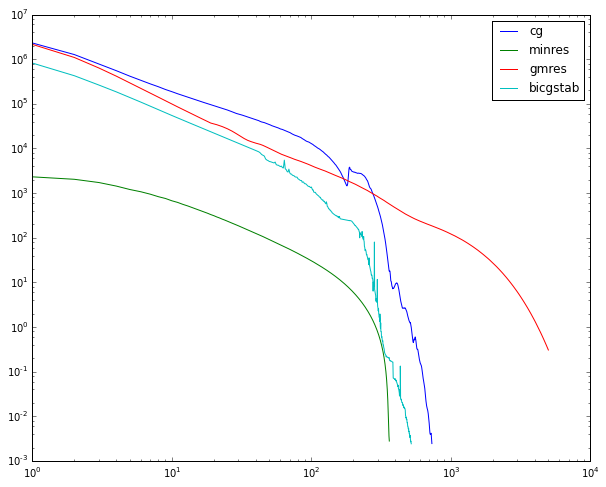

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10,8))
plt.loglog(cg_res, label = 'cg')
plt.loglog(minres_res, label = 'minres')
plt.loglog(gmres_res, label = 'gmres')
plt.loglog(bicgstab_res, label = 'bicgstab')
plt.legend(loc='best')

* What is the method of choice among `cg`, `minres`, `GMRES`, `BicgStab` for this problem? Why? Name advantages and disadvantages of these methods.

The operator A is hermitian so `minres` is suitable for this task. Also A < 0, it means that we can use `cg` for system $-Au = -f$. `GMRES` didn't converge for 5k iterations.

* Solve the system via an appropriate Krylov method with and without ILU preconditioner (play with different ILU preconditioners and find the one with the smallest number of iterations for this particular problem). To illustrate your answer plot residuals for different ILU preconditioners on one plot. Do you think that less iterations will give you reduced calculation time?

In this case the most appropriate method is `BicgStab` because of after using preconditioner operator become nonhermitian. Each iteration takes more time, but for all iterations it depends on quality of preconditioner.
The smallest number of iterations - $35$ is achieved when drop tolerance is $1/100$ and fill factor is $10$.

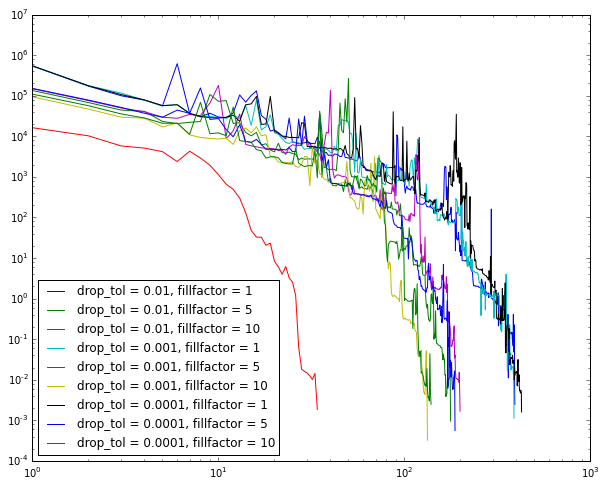

In [38]:
drop_tol = [1e-2, 1e-3, 1e-4]
fill_factor = [1, 5, 10]

plt.figure(figsize = (10, 8))

for dt in drop_tol:
    for ff in fill_factor:
        bicgstab_res = []
        ILU = linalg.spilu(A, drop_tol = dt, fill_factor = ff)
        M = linalg.LinearOperator(shape = (N ** 2, N ** 2), matvec = ILU.solve)
        linalg.bicgstab(A, f, x0 = u0, tol = tolerance, M = M, callback=callback(bicgstab_res))
        plt.loglog(bicgstab_res, label = 'drop_tol = {}, fillfactor = {}'.format(dt, ff))
        
plt.legend(loc = 'best')

* **Bonus:** Find analytically eigenvalues of the matrix $A_h$ and prove that $\text{cond}( A_h )= \mathcal{O}\left(\frac{1}{h^2}\right)$

Let's $u_{jk} = e^{i(\alpha j + \beta k)}$
$$\frac{u_{j+1,k} - 2u_{j,k} + u_{j-1,k}}{h^2} + \frac{u_{j,k+1} - 2u_{j,k} + u_{j,k-1}}{h^2} = -\frac{u_{jk}}{h^2}(2 - 2\cos{\alpha} + 2 - 2\cos{\beta}) = -\frac{u_{jk}}{h^2}(2\sin^2{\alpha/2} + 2\sin^2{\beta/2})$$
We can see that it is eigenvector, but it should satisfy boundary conditions. To do that a linear combination can be made with equal $|\alpha|$ and $|\beta|$.
$$u^{nm}_{ij} = \sin{\pi n h i}\sin{\pi m h j}$$
$$\lambda_{max} = -4\sin^2{\pi(N - 1)h/2}$$
$$\lambda_{min} = -4\sin^2{\pi h/2}$$
$$\text{cond}_2( A_h ) = \frac{sin^2{\pi(N - 1)h/2}}{sin^2{\pi h/2}} = \frac{1}{\tan^2{\pi h/2}} = \mathcal{O}\left(\frac{1}{h^2}\right)$$
$$\text{cond}( A_h ) = \mathcal{O}(\text{cond}_2( A_h )) = \mathcal{O}\left(\frac{1}{h^2}\right)$$

## Problem 2 Deconvolution (Structured matrices)

## 50 pts + 30 pts

In the problem set 2 you were asked to find convolution of the Lena image with the following filter
$$
T_{i_1j_1i_2j_2} \equiv T_{i_1-j_1,i_2-j_2} = \frac{\alpha}{\pi} e^{-\alpha \left[(i_1 - j_1)^2 + (i_2 - j_2)^2 \right]}, \quad i_1,j_1, i_2, j_2 = 1,\dots, n, \quad \alpha = \frac{1}{50}
$$

* Write matvec function that produces multiplication of $T$ by a given vector $x$. Use `scipy.sparse.linalg.LinearOperator` to create an object that has attribute `.dot()` (this object will be further used in the iterative process). Note that `.dot()` input and output must be 1D vectors, so the function `np.reshape` will be usefull.

* Convolve Lena with $T$ for $\alpha = \frac{1}{100}$ using the obtained Linear Operator. Plot the result as an image.

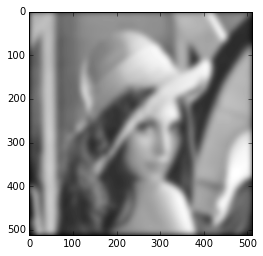

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import LinearOperator
from scipy import misc
%matplotlib inline 

lena = misc.lena()
n = lena.shape[0]
m = lena.shape[1]

def fast_convolution2d(alpha, x):
    x = x.reshape((n, m))
    x_ind = np.append(np.arange(n), np.arange(n - 1) - n + 1)
    y_ind = np.append(np.arange(m), np.arange(m - 1) - m + 1)
    i, j = np.meshgrid(x_ind, y_ind)
    v = np.copy(x)
    v = np.pad(v, ((0, n - 1), (0, m - 1)), 'constant')
    T = alpha / np.pi * np.exp(-alpha * (i ** 2 + j ** 2))
    return np.reshape(np.real(np.fft.ifft2(np.fft.fft2(T) * np.fft.fft2(v))[:n, :m]), n * m)

def T(alpha):
    f = lambda x: fast_convolution2d(alpha, x)
    return LinearOperator((n * m, n * m), matvec = f, rmatvec = f)

smoothedLena = T(1./100).dot(lena.reshape((n * m)))
plt.imshow(smoothedLena.reshape((n, m)), cmap = 'gray')

* Run an appropriate Krylov method with the obtained Linear Operator and try to reconstruct Lena using the right hand side from the previous bullet (smoothed Lena). Plot norm of residual with respect to the number of iterations for different $\alpha$ and corresponding right hand side. Comment on the results.

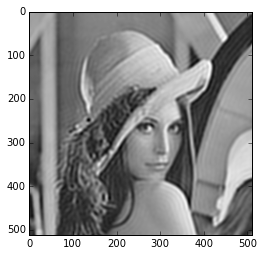

In [2]:
import scipy.sparse.linalg as linalg
plt.imshow(linalg.cg(T(1./100), smoothedLena)[0].reshape((n, m)), cmap = 'gray')

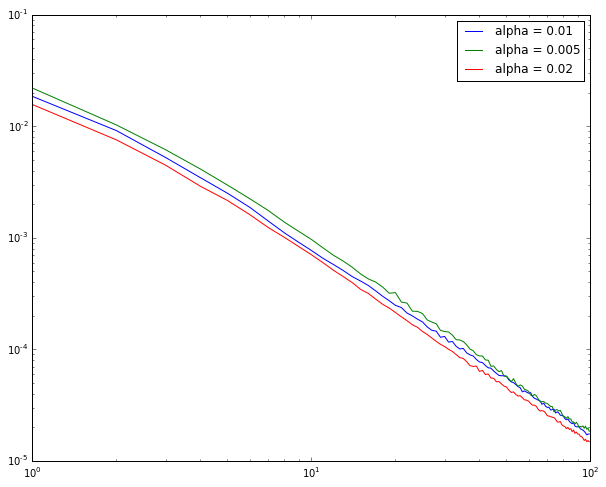

In [19]:
alphas = [1./100, 1./200, 1./50]
lena = lena.reshape((n * m))
lena = lena.astype(np.float)
plt.figure(figsize = (10, 8))

def callback(lena, T, xk):
    resid = np.linalg.norm(T.dot(xk) - lena) / np.linalg.norm(lena)
    res.append(resid)
    
for alpha in alphas:
    Ta = T(alpha)
    smoothedLena = Ta.dot(lena)
    res = []
    linalg.cg(Ta, smoothedLena, tol=1e-5, maxiter=100, callback=lambda x: callback(smoothedLena, Ta, x))
    plt.loglog(res, label = 'alpha = {}'.format(alpha))
    
plt.legend(loc = 'best')

For smaller $\alpha$s slower convergence is observed.

Find image with your name in the attached to this problem set file. This image is the convolution with $T$ for $\alpha=\frac{1}{15}$ with small random noise:
<img src='noise.png' width=300>

The original image looks like
<img src='orig.png'>

It contains 3 code lines (e.g. yOu, ArE, aWEs0me).
Your goal now is to recognize these 3 codes. Each of them will give you extra 10 pts. Since the problem is very ill-posed you need some regularization techniques, such as Tikhonov regularization. 

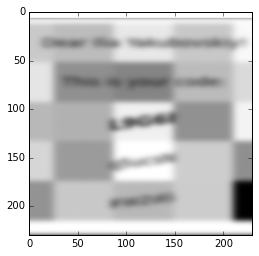

In [57]:
from scipy.ndimage import imread
image = imread('Ilia Yakubovskiy.png', flatten = True)
n = image.shape[0]
m = image.shape[1]
image_v = image.reshape((n * m))
plt.imshow(image, cmap = 'gray')

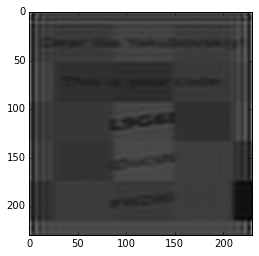

In [78]:
Ta = T(1./15)
reimage = linalg.lsmr(Ta, image_v, damp=0.02, atol=1e-4, btol=1e-4, maxiter = 30)[0]
plt.imshow(reimage.reshape((n, m)), cmap = 'gray')

The first word is `LDC61`.